# Decision Making Introduction 

We analyze data from a two-alternative forced choice task (2AFC) https://en.wikipedia.org/wiki/Two-alternative_forced_choice. In these tasks, ambiguous evidence for two alternative choices is presented to an observer. The ambiguity results in imperfect performance, that varies with the strength of the ambiguity. This relationship is quantified by the "psychometric function".

![title](fig/task.gif)

![title](fig/Random_Dot.gif)

## Prerequisites
- two-alternative forced choice task
- the psychometric function relates an observer's performance to the observed stimulus
- basic Python skills


## Objectives
- handling the data with Python Pandas
- perform elementary data analysis steps on real data
- calculate a psychometric function from data

# Notebook setup 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# Problem 1: Monkey dot data

![title](fig/example.jpg)

# Data exploration with Pandas

## Load the data

- Read the data from file 'dots_psychophysics.txt'
- Each line is one trial, the columnns encode
    - coherence of random dot pattern
    - direction of random dot pattern
    - the direction the monkey chose
    - if the monkey was rewarded
    - the monkey's reaction time
- direction / choice is encoded as: 1 = 0% coherence, 2 = left, 3 = right
- on 0% coherence trials the monkey was rewarded randomly

In [2]:
### Read the psychophysical data via pandas

dotsData = pd.read_csv('data/dots_psychophysics.txt', 
                       delimiter=' ', 
                       skipinitialspace=True, 
                       names=['coherence', 'direction', 'choice', 'rewarded', 'rt'])
dotsData.head()

,coherence,direction,choice,rewarded,rt
0,0.128,2.0,2.0,1.0,622.675
1,0.000,1.0,1.0,1.0,934.450
2,0.000,1.0,1.0,1.0,837.475
3,0.512,2.0,2.0,1.0,349.500
4,0.256,2.0,2.0,1.0,415.925


**NOTE:**

- direction == 1 encodes 0% coherence stimuli
- direction == 2 encodes 'left' stimuli
- direction == 3 encodes 'right' stimuli

In [3]:
dotsData.replace({'direction': {1.: '0%', 2.: 'left', 3.: 'right'},
                  'choice': {1.: '0%', 2.: 'left', 3.: 'right'},
                 }, inplace=True)
dotsData['rewarded'] = dotsData['rewarded'].astype(bool)
dotsData.head()

,coherence,direction,choice,rewarded,rt
0,0.128,left,left,True,622.675
1,0.000,0%,0%,True,934.450
2,0.000,0%,0%,True,837.475
3,0.512,left,left,True,349.500
4,0.256,left,left,True,415.925


## Let's play the data!

**Instruction**

- what's the distribution of choices when coherence == 0 (hint: xxx.groupby() / xxx.count())?

Text(0, 0.5, 'fraction of trials chosen')

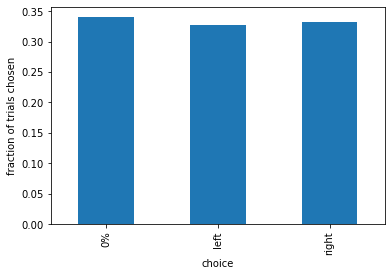

In [4]:
nChoicesAt0Coherence = dotsData[dotsData['coherence'] == 0.] \
                                .groupby('choice') \
                                .count() \
                                ['coherence'] # all columns contain the same information

# normalize to proportions
fracChoisesAt0Coherence = nChoicesAt0Coherence / nChoicesAt0Coherence.sum()
fracChoisesAt0Coherence.plot(kind='bar')
plt.ylabel('fraction of trials chosen')

**Instruction**

- For non-zero-coherence trials, is it true that whenever direction == choice then rewarded == True?

In [5]:
coherentTrials = dotsData[dotsData['coherence'] != 0.]
coherentTrials[coherentTrials['direction'] == coherentTrials['choice']] \
        ['rewarded'] \
        .unique()

array([ True, False])

* Does this make sense?
* Next, compare the reaction times for non-rewarded and rewarded trials

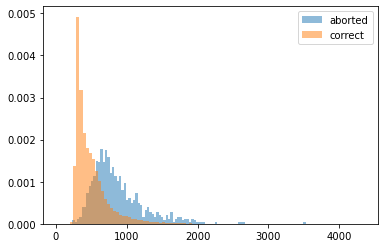

In [6]:
cond_aborted = (dotsData['coherence'] > 0) & \
         (dotsData['direction'] == dotsData['choice']) & \
         (dotsData['rewarded'] == False)
cond_correct = (dotsData['coherence'] > 0) & \
         (dotsData['direction'] == dotsData['choice']) & \
         (dotsData['rewarded'] == True)
        
dotsData[cond_aborted]['rt'].hist(density=True, grid=False, alpha=0.5, bins=100, label='aborted')
dotsData[cond_correct]['rt'].hist(density=True, grid=False, alpha=0.5, bins=100, label='correct')

plt.legend()

## Let's go on!

**Instruction**

How much data do we have, broken down by direction?
Make a bar plot of the number of trials, broken down by stimulus direction and coherence. Don't forget axes labels and a plot title.

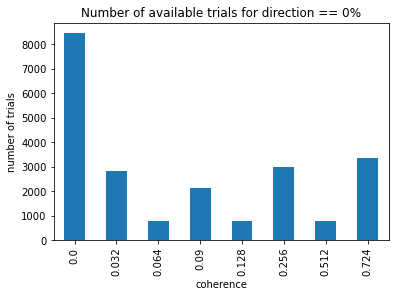

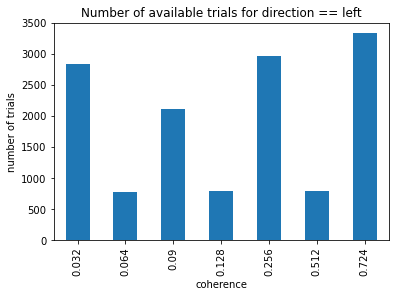

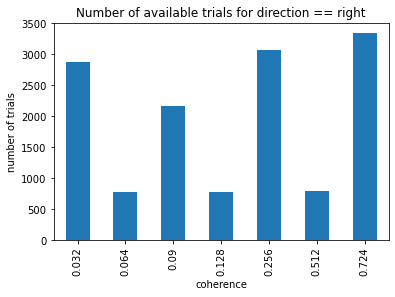

In [7]:
for direction, directionData in dotsData.groupby('direction'):
    plt.figure()
    plt.title('Number of available trials for direction == %s' % direction)
    directionData.groupby('coherence')['coherence'] \
                    .count() \
                    .plot(kind='bar')
    plt.ylabel('number of trials')

# Psychometric function

**Instruction**

Plot the psychometric function, i.e. fraction of correct choices vs. coherence

- once collapsing all directions
- once keeping directions (i.e. plot fraction of right choices for all coherence levels, where for left choices coherence is set to negative values)

### Aborted trials

Filter out aborted trials, i.e. trials in which the monkey chose the stimulus direction but wasn't rewarded

In [8]:
dotsData = dotsData[~cond_aborted]

### Use all directions

Text(0, 0.5, 'fraction of correct trials')

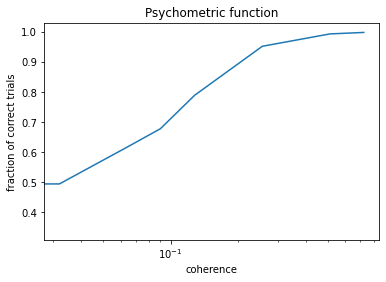

In [9]:
dotsData.groupby('coherence') \
        .apply(lambda df: (df['choice'] == df['direction']).mean()) \
        .plot(logx=True)
plt.title('Psychometric function')
plt.ylabel('fraction of correct trials')

### Use only direction == 'left' and direction == 'right' trials

Text(0.5, 1.0, 'Psychometric function')

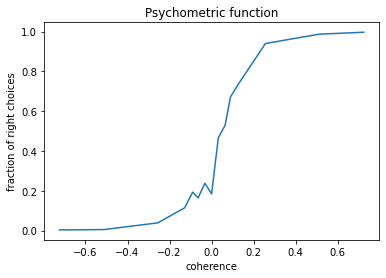

In [12]:
zeroPsychometricFunction = pd.Series((dotsData[dotsData['direction'] == '0%']['choice'] == 'right').mean(), index=[0.])
    
rightPsychometricFunction = dotsData[dotsData['direction'] == 'right'] \
                            .groupby('coherence') \
                            .apply(lambda df: (df['choice'] == 'right').mean())
        
leftPsychometricFunction = dotsData[dotsData['direction'] == 'left'] \
                            .groupby('coherence') \
                            .apply(lambda df: (df['choice'] == 'right').mean())
# flip sign of coherence (which is the index) for leftPsychometricFunction to combine left and right afterwards
leftPsychometricFunction.index *= -1

# combine the three psychometric functions in one Series
psychometricFunction = pd.concat([leftPsychometricFunction, zeroPsychometricFunction, rightPsychometricFunction]) \
                            .sort_index()

psychometricFunction.plot()
plt.xlabel('coherence')
plt.ylabel('fraction of right choices')
plt.title('Psychometric function')

# [Small project] Rat odor data

## Load data

** Instructions **

- load the file "data/odor_psychophysics.csv'
- the columns represent: 'rat', 'session', 'direction', 'contrast', 'choice', 'rewarded'
- analyze the data
- in particular
    - plot the psychometric curve for each rat
    - plot the mean psychometric curve for all rats including error bars

In [12]:
odorData = pd.read_csv('data/odor_psychophysics.csv', 
                       index_col=None, header=None, 
                       names=['rat', 'session', 'direction', 'contrast', 'choice', 'rewarded'])
odorData.head()

,rat,session,direction,contrast,choice,rewarded
0,1,15342,2,0.9,2,1
1,1,15342,3,0.9,3,1
2,1,15342,3,0.9,3,1
3,1,15342,3,0.9,3,1
4,1,15342,2,0.6,3,0


In [13]:
def psychometricFunction(df):
    return df.groupby('contrast') \
            .apply(lambda df_: (df_['direction'] == df_['choice']).mean())

psychometricFunctions = odorData.groupby('rat').apply(psychometricFunction)
psychometricFunctions

contrast,0.12,0.36,0.60,0.90
rat,,,,
1,0.575000,0.634846,0.747564,0.793683
2,0.541863,0.626888,0.693548,0.817472
3,0.585831,0.714642,0.793299,0.855190
4,0.546788,0.683179,0.754785,0.825890
5,0.622864,0.807696,0.871071,0.861981
6,0.597091,0.769888,0.875277,0.861751
7,0.597585,0.770791,0.856212,0.812541
8,0.592400,0.763509,0.842472,0.869632


(0.0, 1.0)

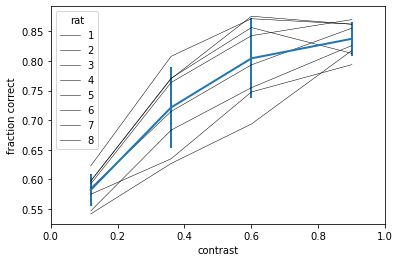

In [14]:
psychometricFunctions.T.plot(color='k', lw=.5)

psychoFun_mean = psychometricFunctions.mean(axis=0)
psychoFun_std = psychometricFunctions.std(axis=0)
psychoFun_mean.plot(yerr=psychoFun_std, lw=2)

plt.ylabel('fraction correct')
plt.xlim(0, 1)